## Carga y preparación de datos

In [1]:
%pip install tensorflow

In [2]:
%pip install pandas
%pip install numpy

In [3]:
# Librerias
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [4]:
# Load the datasets
consumo_df = pd.read_csv('./CONSUMO.csv')
importacion_df = pd.read_csv('./IMPORTACION.csv')
precios_df = pd.read_csv('./PRECIOS.csv')

# Display the first few rows of each dataset to understand their structure
consumo_df.head(), importacion_df.head(), precios_df.head()

# Rellenar valores NaN en precios_df mediante interpolación
precios_df.interpolate(method='linear', inplace=True)

# Verificar que no queden valores NaN
print("Valores NaN en precios_df después de interpolar:\n", precios_df.isna().sum())


# Revisar si hay valores NaN
print("Valores NaN en consumo_df:\n", consumo_df.isna().sum())
print("Valores NaN en importacion_df:\n", importacion_df.isna().sum())
print("Valores NaN en precios_df:\n", precios_df.isna().sum())

Valores NaN en precios_df después de interpolar:
 Fecha      0
Regular    0
Super      0
Diesel     0
dtype: int64
Valores NaN en consumo_df:
 Fecha      0
Diesel     0
GLP        0
Regular    0
Super      0
dtype: int64
Valores NaN en importacion_df:
 Fecha      0
Diesel     0
GLP        0
Regular    0
Super      0
dtype: int64
Valores NaN en precios_df:
 Fecha      0
Regular    0
Super      0
Diesel     0
dtype: int64


<ipython-input-4-435fbf5ac543>:10: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  precios_df.interpolate(method='linear', inplace=True)


In [5]:
# Convertir la columna de fecha a tipo datetime
consumo_df['Fecha'] = pd.to_datetime(consumo_df['Fecha'])
importacion_df['Fecha'] = pd.to_datetime(importacion_df['Fecha'])
precios_df['Fecha'] = pd.to_datetime(precios_df['Fecha'])

# Establecer la fecha como índice
consumo_df.set_index('Fecha', inplace=True)
importacion_df.set_index('Fecha', inplace=True)
precios_df.set_index('Fecha', inplace=True)

# Visualizar las primeras filas de los datos
print(consumo_df.head())
print(importacion_df.head())
print(precios_df.head())

            Diesel            GLP    Regular      Super
Fecha                                                  
2000-01-01     0.0  194410.476190  202645.20  308156.82
2000-02-01     0.0  174710.552381  205530.96  307766.31
2000-03-01     0.0  189234.066667  229499.56  331910.29
2000-04-01     0.0  174330.607143  210680.40  315648.08
2000-05-01     0.0  191745.147619  208164.34  319667.97
            Diesel            GLP    Regular      Super
Fecha                                                  
2001-01-01     0.0  194065.738095  177776.50  373963.96
2001-02-01     0.0  170703.380952  123115.99  243091.07
2001-03-01     0.0  161837.371429  161726.42  312084.38
2001-04-01     0.0  163048.642857  127338.74  285054.89
2001-05-01     0.0  171518.861905  168730.19  300913.67
            Regular  Super  Diesel
Fecha                             
2002-01-01    12.19  12.55    8.95
2002-02-01    11.90  12.29    8.66
2002-03-01    12.17  12.58    8.69
2002-04-01    13.71  14.11    9.38
2002-0

## 2. División de los datos en conjuntos de entrenamiento y prueba

In [6]:
def split_data(data, train_size=0.8):
    train_size = int(len(data) * train_size)
    train, test = data[:train_size], data[train_size:]
    return train, test

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

def preprocess_data(data, time_step=10):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    train, test = split_data(scaled_data)
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    return X_train, y_train, X_test, y_test, scaler


In [7]:

def train_lstm_model(X_train, y_train, units=50, epochs=50, batch_size=1):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model


In [8]:
def train_lstm_model_v2(X_train, y_train, units=100, epochs=50, batch_size=1):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model


In [9]:
def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform([y_test])
    mse = mean_squared_error(y_test[0], predictions[:, 0])
    return mse, predictions


Procesando serie de tiempo: Consumo Regular


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0122
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0018
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0017
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0023
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0019
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0019
Epoch 9/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0018
Epoch 10/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015
Epoch 11/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0016
Epoch 12/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0012
Epoch 13/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0017
Epoch 14/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 15/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/s

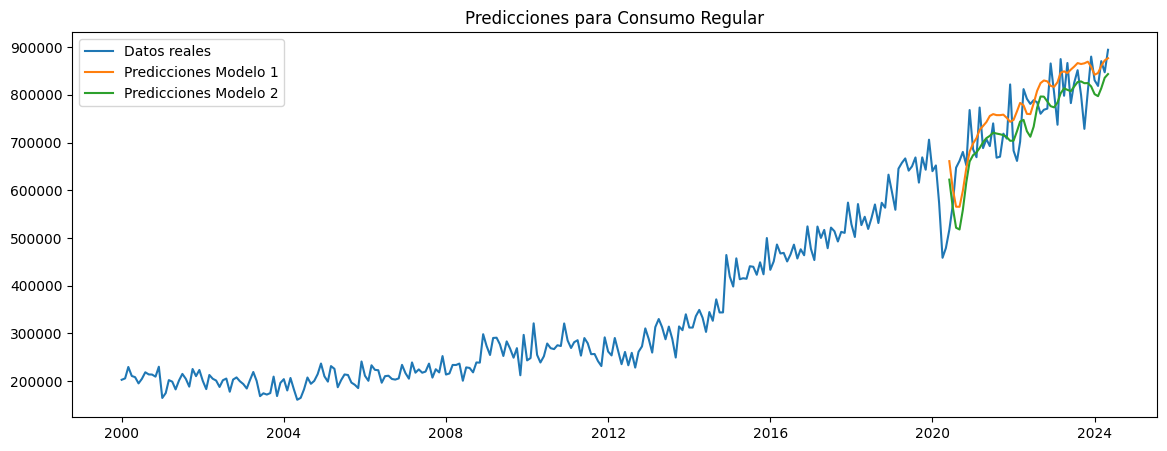

Procesando serie de tiempo: Importación Regular
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0137
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0135
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0098
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0095
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0110
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0095
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0075
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0106
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0114
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0086
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0111
Epoch 12/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0111
Epoch 13/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0107
Epoch 14/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0108
Epoch 15/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


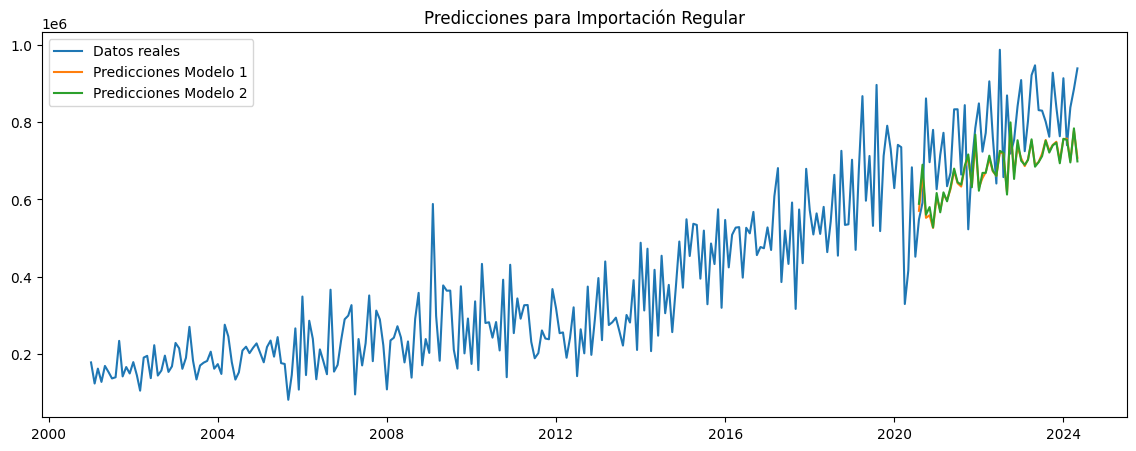

Procesando serie de tiempo: Precios Regular
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0348
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0142
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0108
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0073
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0071
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0044
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0041
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0034
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030
Epoch 11/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0027
Epoch 12/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0023
Epoch 13/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0030
Epoch 14/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0024
Epoch 15/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0

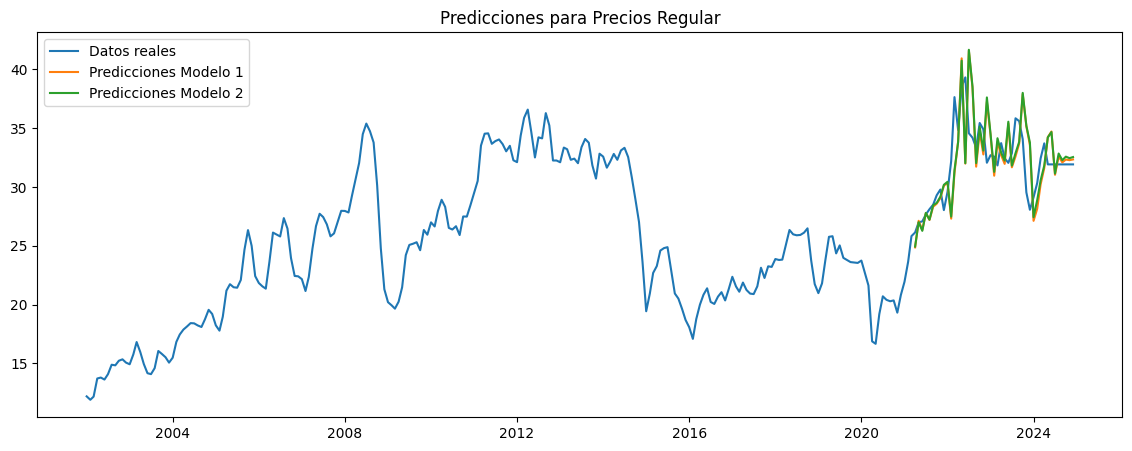

Consumo Regular - MSE Modelo 1: 4128430054.0149274
Consumo Regular - MSE Modelo 2: 3359885438.75914
Importación Regular - MSE Modelo 1: 19219346114.64861
Importación Regular - MSE Modelo 2: 19197134846.465763
Precios Regular - MSE Modelo 1: 4.720558508249839
Precios Regular - MSE Modelo 2: 4.706652907621188


In [10]:
# Series de tiempo: Consumo (Regular), Importación (Regular), Precios (Regular)

series_dict = {
    'Consumo Regular': consumo_df[['Regular']],
    'Importación Regular': importacion_df[['Regular']],
    'Precios Regular': precios_df[['Regular']]
}

results = {}

for name, data in series_dict.items():
    print(f"Procesando serie de tiempo: {name}")

    # Preprocesar los datos
    X_train, y_train, X_test, y_test, scaler = preprocess_data(data.values)

    # Entrenar el primer modelo
    model1 = train_lstm_model(X_train, y_train)

    # Entrenar el segundo modelo
    model2 = train_lstm_model_v2(X_train, y_train)

    # Evaluar el primer modelo
    mse1, predictions1 = evaluate_model(model1, X_test, y_test, scaler)

    # Evaluar el segundo modelo
    mse2, predictions2 = evaluate_model(model2, X_test, y_test, scaler)

    # Almacenar los resultados
    results[name] = {
        'MSE Modelo 1': mse1,
        'MSE Modelo 2': mse2,
        'Predicciones Modelo 1': predictions1,
        'Predicciones Modelo 2': predictions2
    }

    # Graficar las predicciones
    plt.figure(figsize=(14, 5))
    plt.plot(data.index, data.values, label='Datos reales')
    plt.plot(data.index[len(data) - len(predictions1):], predictions1, label='Predicciones Modelo 1')
    plt.plot(data.index[len(data) - len(predictions2):], predictions2, label='Predicciones Modelo 2')
    plt.title(f'Predicciones para {name}')
    plt.legend()
    plt.show()

for name, result in results.items():
    print(f"{name} - MSE Modelo 1: {result['MSE Modelo 1']}")
    print(f"{name} - MSE Modelo 2: {result['MSE Modelo 2']}")


Consumo Regular - MSE Modelo 1: 4128430054.0149274

Consumo Regular - MSE Modelo 2: 3359885438.75914

Importación Regular - MSE Modelo 1: 19219346114.64861

Importación Regular - MSE Modelo 2: 19197134846.465763

Precios Regular - MSE Modelo 1: 4.720558508249839

Precios Regular - MSE Modelo 2: 4.706652907621188


In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam

def train_lstm_model_v3(X_train, y_train, units=100, epochs=50, batch_size=32, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()

    model.add(Bidirectional(LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add(Dropout(dropout_rate))

    model.add(Bidirectional(LSTM(units, return_sequences=False)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    return model


Procesando serie de tiempo: Consumo Super
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0101
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0061
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0048
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0094
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0045
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0054
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0045
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0042
Epoch 9/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0035
Epoch 10/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0052
Epoch 11/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0048
Epoch 12/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0041
Epoch 13/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0039
Epoch 14/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0052
Epoch 15/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step 

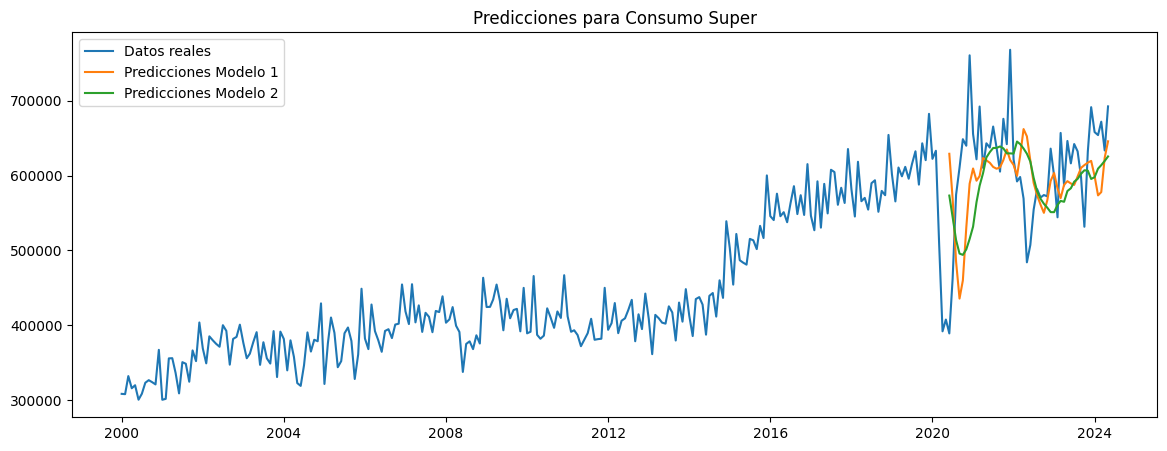

Procesando serie de tiempo: Importación Super
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0130
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0114
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0101
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0111
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0081
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0091
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0109
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0095
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0092
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0078
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0100
Epoch 12/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0087
Epoch 13/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0110
Epoch 14/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0081
Epoch 15/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step 

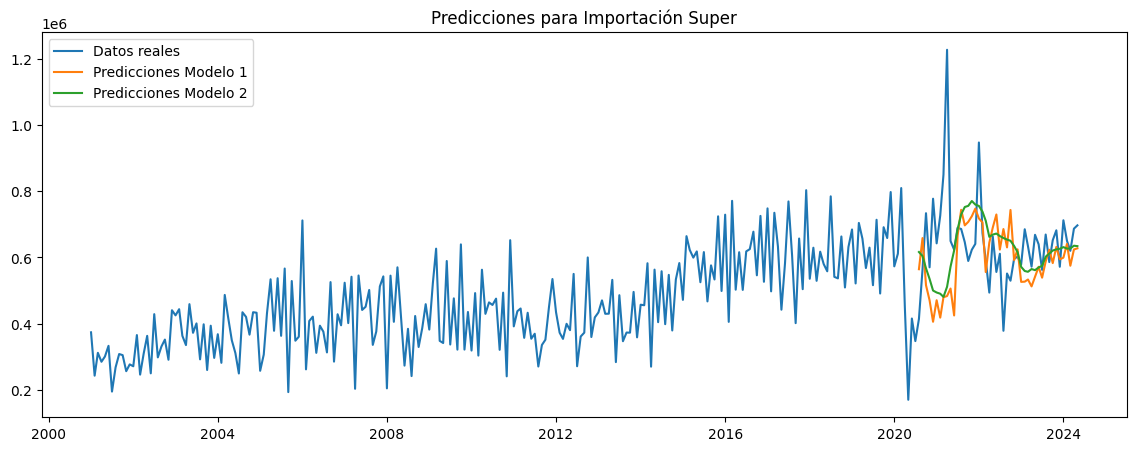

Procesando serie de tiempo: Precios Super
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0198
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0138
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0092
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0084
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0036
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0026
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0027
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0023
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0024
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0021
Epoch 11/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0019
Epoch 12/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0020
Epoch 13/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0024
Epoch 14/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0020
Epoch 15/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step 

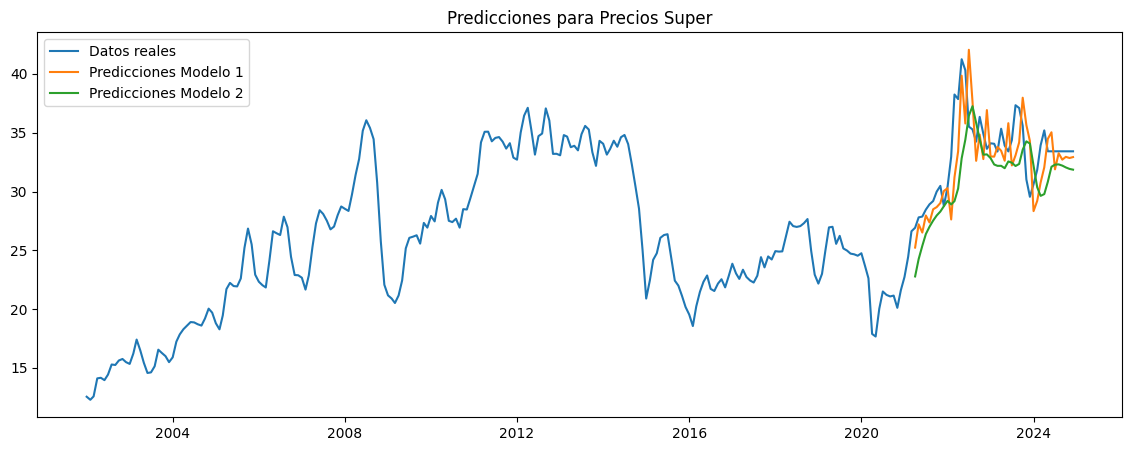

Consumo Super - MSE Modelo 1: 6010472383.084897
Consumo Super - MSE Modelo 2: 6015801762.3087015
Importación Super - MSE Modelo 1: 32366120915.281803
Importación Super - MSE Modelo 2: 26088167026.96068
Precios Super - MSE Modelo 1: 3.570162377045806
Precios Super - MSE Modelo 2: 8.060372675458458


In [13]:
# Series de tiempo: Consumo (Super), Importación (Super), Precios (Super)

series_dict = {
    'Consumo Super': consumo_df[['Super']],
    'Importación Super': importacion_df[['Super']],
    'Precios Super': precios_df[['Super']]
}

results = {}

for name, data in series_dict.items():
    print(f"Procesando serie de tiempo: {name}")

    # Preprocesar los datos
    X_train, y_train, X_test, y_test, scaler = preprocess_data(data.values)

    # Entrenar el primer modelo
    model1 = train_lstm_model_v2(X_train, y_train)

    # Entrenar el segundo modelo
    model2 = train_lstm_model_v3(X_train, y_train)

    # Evaluar el primer modelo
    mse1, predictions1 = evaluate_model(model1, X_test, y_test, scaler)

    # Evaluar el segundo modelo
    mse2, predictions2 = evaluate_model(model2, X_test, y_test, scaler)

    # Almacenar los resultados
    results[name] = {
        'MSE Modelo 1': mse1,
        'MSE Modelo 2': mse2,
        'Predicciones Modelo 1': predictions1,
        'Predicciones Modelo 2': predictions2
    }

    # Graficar las predicciones
    plt.figure(figsize=(14, 5))
    plt.plot(data.index, data.values, label='Datos reales')
    plt.plot(data.index[len(data) - len(predictions1):], predictions1, label='Predicciones Modelo 1')
    plt.plot(data.index[len(data) - len(predictions2):], predictions2, label='Predicciones Modelo 2')
    plt.title(f'Predicciones para {name}')
    plt.legend()
    plt.show()

for name, result in results.items():
    print(f"{name} - MSE Modelo 1: {result['MSE Modelo 1']}")
    print(f"{name} - MSE Modelo 2: {result['MSE Modelo 2']}")

Consumo Super - MSE Modelo 1: 6010472383.084897

Consumo Super - MSE Modelo 2: 6015801762.3087015

Importación Super - MSE Modelo 1: 32366120915.281803

Importación Super - MSE Modelo 2: 26088167026.96068

Precios Super - MSE Modelo 1: 3.570162377045806

Precios Super - MSE Modelo 2: 8.060372675458458